In [1]:
from dynamics import *
from problem import *
import numpy as np
from casadi import *
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter

In [54]:
from decentralized import util

In [2]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a single quadrotor:

In [ ]:
# x0 = np.random.rand(6*3,1)
x0 = np.array([0.1, 0.1, 1.0, 0.1, 0.1, 0.1])
xf = np.array([1.2, 1.2, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000
g = 9.8

u_ref = np.array([0,0,g])
N = 100

opti = Opti()

dt = 0.05

In [ ]:
# models = [quad6D,quad6D,quad6D]

In [ ]:
# ids = [i for i in range(n_agents)]

In [ ]:
# quad6D(xf,Q,R,Qf,u_ref,N).cost()

In [ ]:
# dynamics = MultiDynamicalModel([model(split_agents(xf.T,x_dims)[id_],Q,R,Qf,split_agents(u_ref.T,u_dims)[id_],N) for model,id_ in zip(models,ids)])

In [ ]:
# problem = quadProblem()

In [ ]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [ ]:
# x_dims = [6,6,6,6]

In [ ]:
g = 9.81

In [ ]:
f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)

In [ ]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps


In [ ]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [ ]:
objective = total_terminal_cost + total_stage_cost
# objective = total_stage_cost


In [ ]:
opti.minimize(objective) 

In [ ]:
opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
opti.subject_to(0.4<=X[2,:])

opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
opti.subject_to(-np.pi/6<=U[0,:])

opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
opti.subject_to(-np.pi/6<=U[1,:])

opti.subject_to(U[2,:]<=25) # tau is limited
opti.subject_to(0<=U[2,:]) #minimum force 

# opti.subject_to(X[0:3,-1] == xf[0:3])
#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver("ipopt")
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')


In [ ]:
X_trj = sol.value(X)
U_trj = sol.value(U)

In [ ]:
U_trj.shape

In [ ]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization')


In [ ]:
pos_err = np.linalg.norm(X_trj[0:3,-1]-xf[0:3])
pos_err

## Running the above optimizaiton but in a receding-horizon fashion:
In this case, we relax the terminal state constraint and impose a terminal state cost into the objective function. The reason is that each optimization step is solved over a control horizon, and it's not possible that the drone reaches its goal after each control horizon (which keeps shifting forward)

In [3]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost
    # return total_stage_cost

In [ ]:
x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0])
xf = np.array([1.3, 1.1, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000

# u_ref = np.zeros((3,1))
u_ref = np.array([0,0,9.8])

In [ ]:
n_agents = 1
n_states = 6
n_inputs=  3

In [ ]:
def solve_rhc(x0,xf,u_ref,N,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 100,"print_level":4}
    
    opti = Opti()
    M = 100 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    
    f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)
    
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
    
        X = opti.variable(6,N+1)
        U = opti.variable(3,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps

        opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
        opti.subject_to(0.4<=X[2,:])

        opti.subject_to(X[0,:]<=3) # p_x is limited
        opti.subject_to(-3<=X[0,:])

        opti.subject_to(X[1,:]<=3) # p_y is limited
        opti.subject_to(-3<=X[1,:])
        
        opti.subject_to(X[3,:] <=5) #Vx is limited
        opti.subject_to(0 <= X[3,:])
        
        opti.subject_to(X[4,:] <=5) #Vy is limited
        opti.subject_to(0 <= X[4,:])
        
        opti.subject_to(X[5,:] <=5) #Vz is limited
        opti.subject_to(0 <= X[5,:])

        opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
        opti.subject_to(-np.pi/6<=U[0,:])

        opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
        opti.subject_to(-np.pi/6<=U[1,:])

        opti.subject_to(U[2,:]<=20) # tau is limited
        opti.subject_to(0<=U[2,:]) #minimum force keeps the drone at hover

        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)

        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        J_list.append(sol.value(cost_fun))
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        if abs(J_list[i]-J_list[i-1]) <= 10 :
            print(f'Terminated! at i = {i}')
            break
        
        
    return X_full,U_full, t
    

In [ ]:
from time import perf_counter

In [ ]:
N = 5
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

In [ ]:
x_trj.shape

In [ ]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_trj[:,0],x_trj[:,1],x_trj[:,2])
ax.set_title('Trajectory with receding horizon')

In [ ]:
x0

In [ ]:
xf

In [ ]:
pos_err = np.linalg.norm(x_trj[-1,0:3]-xf[0:3])

In [ ]:
pos_err  #not bad!


## Running 3 drones in a centralized fashion:

In [15]:
x0,xf = paper_setup_3_quads()

In [298]:
xf.shape

(18, 1)

In [16]:
g = 9.81

In [349]:
n_agents = 3
n_states = 6
n_inputs=  3


# Qs = [Q] * n_agents
# Rs = [R] * n_agents
# Qfs = [Qf] * n_agents
# x_dims = [n_states]*n_agents
# u_dims = [n_inputs]*n_agents

In [350]:
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])
Q = np.diag([5,5,5,1,1,1,5,5,5,1,1,1,5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

In [351]:
theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

In [352]:
x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

In [353]:
max_input = np.array([[theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max]])

min_input = np.array([[theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min]])

max_state_upper = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
    
max_state_lower = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

In [354]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [355]:
eps = 1e-3

In [356]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g) #dx/dt = f(x,u)

In [343]:
def solve_rhc(x0,xf,u_ref,N,Q,R,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 150,"print_level":2}
    
    
    M = 200 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    x_dims = [n_states]*n_agents
    
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
        
        
        opti = Opti()
        X = opti.variable(n_x,N+1)
        U = opti.variable(n_u,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps
            
            #Constraints on inputs:
            for j in range(max_input.shape[0]):

                opti.subject_to(U[j,k] <= max_input[j] )
                opti.subject_to(min_input[j] <= U[j,k] )
                
        #Hard-coding collision avoidance constraints:
        # for k in range(N+1):    
        #     #Collision avoidance:
        #     opti.subject_to(-sqrt((X[0,k]-X[6,k])**2+ (X[1,k]-X[7,k])**2 +(X[2,k]-X[8,k])**2 + eps)  <= -0.5)
        #     opti.subject_to(-sqrt((X[0,k]-X[12,k])**2 +(X[1,k]-X[13,k])**2 +(X[2,k]-X[14,k])**2 + eps) <= -0.5)
        #     opti.subject_to(-sqrt((X[12,k]-X[6,k])**2 +(X[13,k]-X[7,k])**2 +(X[14,k]-X[8,k])**2 + eps) <= -0.5)
        
        #collision avoidance
        for k in range(N+1):
            distances = compute_pairwise_distance_Sym(X[:,k], x_dims)
            for n in range(len(distances)):
                opti.subject_to(distances[n] >= 0.5)
                
            #constraints on states:
            for m in range(max_state_lower.shape[0]):

                opti.subject_to(X[m,k]<= max_state_upper[m] )
                opti.subject_to(max_state_lower[m] <= X[m,k])

            
        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        
        J_list.append(sol.value(cost_fun))
        print(f'current objective function value is {sol.value(cost_fun)}')
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        # print(opti.variable) #print this to check the optimization parameters for each control horizon
        
        if abs(J_list[i]-J_list[i-1]) <= 1.0 :
            print(f'Terminated! at i = {i}')
            break
            
        
    return X_full,U_full, t

In [344]:
N = 15
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 237.20us (  6.59us)        36
       nlp_g  |        0 (       0) 795.60us ( 22.10us)        36
  nlp_grad_f  |        0 (       0) 321.20us (  9.45us)        34
  nlp_hess_l  |        0 (       0)   1.09ms ( 34.14us)        32
   nlp_jac_g  |        0 (       0)   1.11ms ( 32.76us)        34
       total  | 203.12ms (203.12ms) 207.49ms (207.49ms)         1
current objective function value is 3221.042328597976
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 264.20us (  6.77us)        39
       nlp_g  |        0 (       0) 904.90us ( 23.20us)        39
  nlp_grad_f  |        0 (       0) 395.10us ( 10.40us)        38
  nlp_hess_l  |        0 (       0)   1.28ms ( 35.55us)        36
   nlp_jac_g  |        0 (       0)   1.30ms ( 34.27us)        38
       total  | 234.38ms (234.38ms) 236.95ms (236.95ms)         1
current objective func

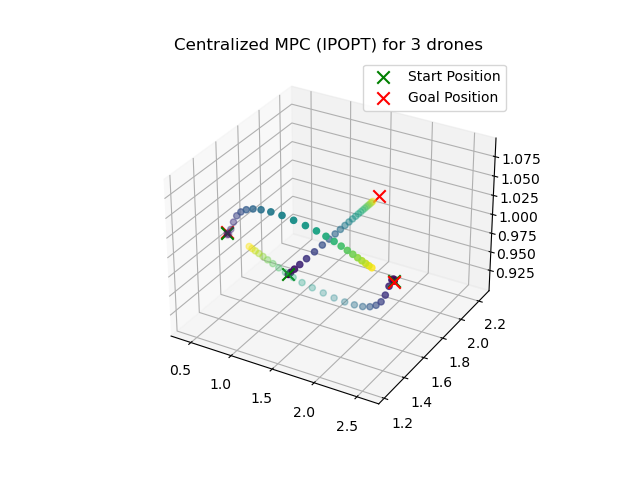

In [345]:
plt.figure()
util.plot_solve(x_trj,6.2, xf, [6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 3 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Centralized MPC (IPOPT) for 3 drones.png')

## Todo: run the centralized MPC above for up to 10 drones:

## Now run the above optimization problem in distributed fashion using game-potential formulation:

In [100]:
n_agents = 3

In [101]:
ids = [100 + i for i in range(n_agents)]

In [357]:
def define_inter_graph_threshold(X, radius, x_dims, ids):
    """
    Compute the interaction graph based on a simple thresholded distance
    for each pair of agents at a specific time step
    (X is a one-dimensional array)
    """
    
    
    #radius is the collision avoidance threshold
    #Planning_radii is the threshold distance below which two agents are combined into a sub problem
    planning_radii = 2 * radius
   
    rel_dists = util.compute_pairwise_distance(X, x_dims)

    # N = X.shape[0]
    # n_samples = 10
    # sample_step = max(N // n_samples, 1)
    # sample_slice = slice(0, N + 1, sample_step)

    # Put each pair of agents within each others' graphs if they are within
    # some threshold distance from each other.
    graph = {id_: [id_] for id_ in ids}
    pair_inds = np.array(list(itertools.combinations(ids, 2)))
   
    for i, pair in enumerate(pair_inds):
    
        if np.any(rel_dists.flatten()[i] < planning_radii):
            graph[pair[0]].append(pair[1])
            graph[pair[1]].append(pair[0])

    graph = {agent_id: sorted(prob_ids) for agent_id, prob_ids in graph.items()}
    return graph

In [358]:
graph = define_inter_graph_threshold(x0.T*0.5, 0.5, x_dims, ids)

In [404]:
split_problem_states = split_graph(x0.T,x_dims,graph)
split_problem_states

[array([[0.5, 1.5, 1. , 0. , 0. , 0. , 1.5, 1.3, 1. , 0. , 0. , 0. ]]),
 array([[2.5, 1.5, 1. , 0. , 0. , 0. , 1.5, 1.3, 1. , 0. , 0. , 0. ]]),
 array([[0.5, 1.5, 1. , 0. , 0. , 0. , 2.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
         1.3, 1. , 0. , 0. , 0. ]])]

In [405]:
split_problem_inputs = split_graph(u_ref.reshape(-1,1).T,u_dims,graph)
split_problem_inputs

[array([[0.  , 0.  , 9.81, 0.  , 0.  , 9.81]]),
 array([[0.  , 0.  , 9.81, 0.  , 0.  , 9.81]]),
 array([[0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81]])]

In [457]:
#build a dictionary holding numerous Opti() objects
d = {}
states = {}
inputs = {}
cost_fun_list = []
for i,j in enumerate(split_graph(x0.T,x_dims,graph)):
    d["opti_{0}".format(i)] = Opti()
    states['X_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N+1) 
    
for i,j in enumerate(split_graph(u_ref.reshape(-1,1).T,u_dims,graph)):
    inputs['U_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N)
    
for i in range(len(split_problem_states)):
    cost_fun_list.append(objective(states[f'X_{i}'],\
                           inputs[f'U_{i}'],\
                           split_problem_inputs[i].reshape(-1,),\
                           split_problem_states[i].reshape(-1,1),\
                           np.eye(split_problem_states[i].shape[1]),
                           np.eye(split_problem_inputs[i].reshape(-1,).shape[0])*0.01,
                           np.eye(split_problem_states[i].shape[1])*100))

In [410]:
# objective(states[f'X_{0}'],\
#           inputs[f'U_{0}'],\
#           split_graph(u_ref.reshape(-1,1).T,u_dims,graph)[0].reshape(-1,),\
#           split_graph(xf.T,x_dims,graph)[0].reshape(-1,1),\
#           np.eye(n_states * split_problem[0].shape[1]),
#           np.eye(n_inputs * split_problem[0].shape[1]),
#           np.eye(n_states * split_problem[0].shape[1])*100)

In [ ]:
def solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids):
    Qs = [Q] * n_agents
    Rs = [R] * n_agents
    Qfs = [Qf] * n_agents
    x_dims = [n_states]*n_agents
    u_dims = [n_inputs]*n_agents
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 150,"print_level":2}
    
    
    M = 200 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    x_dims = [n_states]*n_agents
    
    
    X_dec = np.zeros((N + 1, n_agents * n_states))
    U_dec = np.zeros((N, n_agents * n_controls))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
        #determine sub problems to solve:
     
        #compute numerical pairwise distances at current time step:
        # dist_init = util.compute_pairwise_distance(x0,x_dims)
        
        #compute interaction graph at the current time step:
        graph_init = define_inter_graph_threshold(x0, radius, x_dims, ids)
        
        #break up the problem into potential-game sub-problems:
        split_problem_states = split_graph(x0.T,x_dims,graph)
        split_problem_inputs = split_graph(u_ref.reshape(-1,1).T,u_dims,graph)
        
        #Initiate different instances of Opti() object
        #Each Opti() object corresponds to a subproblem
        #Note that when 2 agents are combined into a single problem, we have 2 copies of the same sub problem
        
        d = {}
        states = {}
        inputs = {}
        cost_fun_list = [] 
        
        d = {}
        states = {}
        inputs = {}
        
       
        for i,j in enumerate(split_problem_states):
            d["opti_{0}".format(i)] = Opti()
            states['X_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N+1) 

        for i,j in enumerate(split_problem_inputs):
            inputs['U_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N)
        
        for i in range(len(split_problem_states)):
                    cost_fun_list.append(objective(states[f'X_{i}'],\
                           inputs[f'U_{i}'],\
                           split_problem_inputs[i].reshape(-1,),\
                           split_problem_states[i].reshape(-1,1),\
                           np.eye(split_problem_states[i].shape[1]),
                           np.eye(split_problem_inputs[i].reshape(-1,).shape[0])*0.01,
                           np.eye(split_problem_states[i].shape[1])*100))

        # cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps
            
            #Constraints on inputs:
            for j in range(max_input.shape[0]):

                opti.subject_to(U[j,k] <= max_input[j] )
                opti.subject_to(min_input[j] <= U[j,k] )
     
        #collision avoidance
        for k in range(N+1):
            distances = compute_pairwise_distance_Sym(X[:,k], x_dims)
            for n in range(len(distances)):
                opti.subject_to(distances[n] >= 0.5)
                
            #constraints on states:
            for m in range(max_state_lower.shape[0]):

                opti.subject_to(X[m,k]<= max_state_upper[m] )
                opti.subject_to(max_state_lower[m] <= X[m,k])

            
        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        
        J_list.append(sol.value(cost_fun))
        print(f'current objective function value is {sol.value(cost_fun)}')
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        # print(opti.variable) #print this to check the optimization parameters for each control horizon
        
        if abs(J_list[i]-J_list[i-1]) <= 2.0 :
            print(f'Terminated! at i = {i}')
            break
            
        
    return X_full,U_full, t
    
    